In [30]:
import numpy as np
import os
import random

Configurations

In [192]:
# Here you can change between the different dataset .txts (element_list, movie_titles_list)
# ---IMPORTANT: every time you change a dataset the vocabulary changes 
#              so do not forget to update the vocabulary size where necessary otherwise nothing will run

path_data = os.path.join('data','element_list.txt')
#path_data = os.path.join('data','movie_title_list.txt') #path for question 1.F 

In [193]:
data = open(path_data, 'r').read()

data= data.lower()

chars = list(set(data))

data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

There are 1039 total characters and 25 unique characters in your data.


The characters are a-z (26 characters) plus (some extra characters e.g. parenthesis) AND the "\n" (or newline character), which in this assignment plays a role similar to the <EOS> (or "End of sentence") token. This signifies the end of the animal's name or in larger texts the end of a sentence. 

In the cell below, we create a python dictionary (i.e., a hash table) to map each character to an index from 0-32. We also create a second python dictionary that maps each index back to the corresponding character character. This will help you figure out what index corresponds to what character in the probability distribution output of the softmax layer. Below, char_to_ix and ix_to_char are the python dictionaries.

In [194]:
char_to_ix = { ch:i for i,ch in enumerate(sorted(chars)) }
ix_to_char = { i:ch for i,ch in enumerate(sorted(chars)) }
print(ix_to_char)

{0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'r', 17: 's', 18: 't', 19: 'u', 20: 'v', 21: 'w', 22: 'x', 23: 'y', 24: 'z'}


### Overview of the model
Your model will have the following structure:


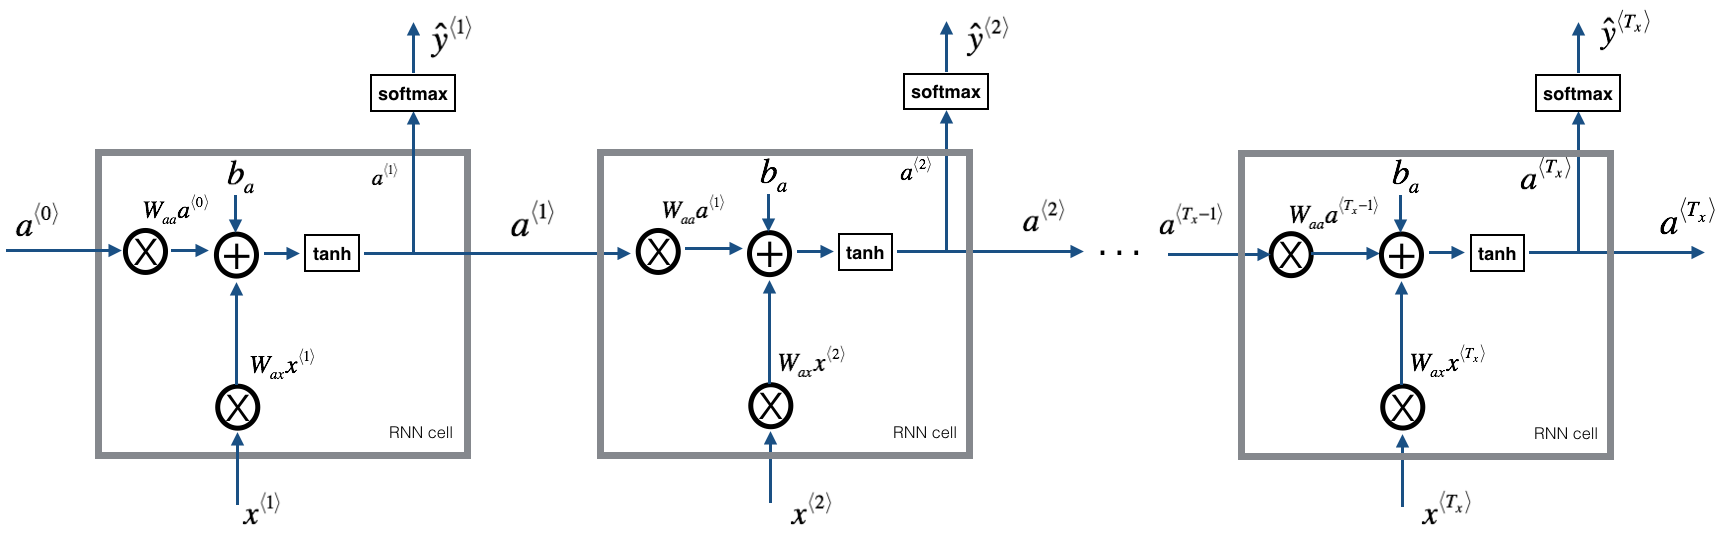


At each time-step, the RNN tries to predict what is the next character given the previous characters. The dataset $X = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$ is a list of characters in the training set, while $Y = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$ is such that at every time-step $t$, we have $y^{\langle t \rangle} = x^{\langle t+1 \rangle}$. "

# **Task 1 - Information flow functions**

Fill in the appropriate parts in the functions bellow to perform the key operations on (a) Forward pass, (b) Backward pass


In [195]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def smooth(loss, cur_loss):
    return loss * 0.999 + cur_loss * 0.001

def print_sample(sample_ix, ix_to_char):
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    txt = txt[0].upper() + txt[1:]  # capitalize first character 
    print ('%s' % (txt, ), end='')

def get_initial_loss(vocab_size, seq_length):
    return -np.log(1.0/vocab_size)*seq_length

def initialize_parameters(n_a, n_x, n_y):
    """
    Initialize parameters with small random values
    
    Returns:
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    """
    np.random.seed(1)
    Wax = np.random.randn(n_a, n_x)*0.01 # input to hidden
    Waa = np.random.randn(n_a, n_a)*0.01 # hidden to hidden
    Wya = np.random.randn(n_y, n_a)*0.01 # hidden to output
    b = np.zeros((n_a, 1)) # hidden bias
    by = np.zeros((n_y, 1)) # output bias
    
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b,"by": by}
    
    return parameters

In [196]:
def rnn_step_forward(parameters, a_prev, x):
    
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']

    ############################################################################
    # Task 1.1 TODO:                                                           #
    # 1. Define the operations that update a at each RNN step                  #
    # (i.e. the value of a that exists the RNN cell),                          #
    # 2 Store the value in a_next                                              #
    # 3. Allowed functions that you can use are (a)np.tanh, (b) np.dot         #
    ############################################################################
    ### START CODE HERE ###
    
    a_next = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b)
    
    ### END CODE HERE ###

    ############################################################################
    # Task 1.2 TODO:                                                           #
    # 1. Define the output of the last cell                                    #
    # (i.e. the value of y that exists the last RNN cell),                     #
    # 2 Store the value in a new variable (don;t forget to use a_next)         #
    # 3. Allowed functions that you can use are (a)softmax, (b) np.dot         #
    ############################################################################
    ### START CODE HERE ###

    p_t = softmax(np.dot(Wya, a_next) + by) #the new variable

    ### END CODE HERE ###

    return a_next, p_t

def rnn_step_backward(dy, gradients, parameters, x, a, a_prev):
    ############################################################################
    # Task 1.3 TODO:  Define the gradients for backprop. The goal is to define #
    # the gradient outputs using formulas computed via backprop                #
    # gradients: dictionary containing the terms                               #
    #            dWya, dby, da_next, db, dWax, dWaa, da_next                   #
    # parameters: dictionary that contains terms                               #
    #              Wya, Waa,                                                   #
    #                                                                          #
    # For the tanh non-linearity backprop use the following formula            #
    #                     out =  (1-x*x)*dx                                    #
    ############################################################################

    ### START CODE HERE ###

    #creating the dictionary containing each grad term
    gradients['dWya'] += np.dot(dy, a.T)
    gradients['dby'] += dy
    da = np.dot(parameters['Wya'].T, dy) + gradients['da_next']
    out = (1 - a * a) * da # backprop through tanh nonlinearity as given above in the comments
    gradients['db'] += out
    gradients['dWax'] += np.dot(out, x.T)
    gradients['dWaa'] += np.dot(out, a_prev.T)
    gradients['da_next'] = np.dot(parameters['Waa'].T, out)

    ### END CODE HERE ###

    return gradients

def update_parameters(parameters, gradients, lr):

    ############################################################################
    # Task 1.4 TODO: Update the network parameters, using the learned gradients#
    #                                                                          #
    # gradients: dictionary containing the terms                               #
    #            dWya, dby, da_next, db, dWax, dWaa, da_next                   #
    # parameters: dictionary that contains terms                               #
    #              Wya, Waa, Wax, b, by                                        #
    ############################################################################

    ### START CODE HERE ###

    #updating of the params using the learned grads 
    parameters['Wax'] += -lr * gradients['dWax']
    parameters['Waa'] += -lr * gradients['dWaa']
    parameters['Wya'] += -lr * gradients['dWya']
    parameters['b']  += -lr * gradients['db']
    parameters['by']  += -lr * gradients['dby']

    ### END CODE HERE ###

    return parameters

def rnn_forward(X, Y, a0, parameters, vocab_size = 25): #vocab_size=25 for element names and 42 for movie names
    
    # Initialize x, a and y_hat as empty dictionaries
    x, a, y_hat = {}, {}, {}
    
    a[-1] = np.copy(a0)
    
    # initialize your loss to 0
    loss = 0
    
    for t in range(len(X)):
        
        # Set x[t] to be the one-hot vector representation of the t'th character in X.
        # if X[t] == None, we just have x[t]=0. This is used to set the input for the first timestep to the zero vector. 
        x[t] = np.zeros((vocab_size,1)) 
        if (X[t] != None):
            x[t][X[t]] = 1
        
        # Run one step forward of the RNN
        a[t], y_hat[t] = rnn_step_forward(parameters, a[t-1], x[t])
        
        # Update the loss by substracting the cross-entropy term of this time-step from it.
        loss -= np.log(y_hat[t][Y[t],0])
        
    cache = (y_hat, a, x)
        
    return loss, cache

def rnn_backward(X, Y, parameters, cache):
    # Initialize gradients as an empty dictionary
    gradients = {}
    
    # Retrieve from cache and parameters
    (y_hat, a, x) = cache
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    
    # each one should be initialized to zeros of the same dimension as its corresponding parameter
    gradients['dWax'], gradients['dWaa'], gradients['dWya'] = np.zeros_like(Wax), np.zeros_like(Waa), np.zeros_like(Wya)
    gradients['db'], gradients['dby'] = np.zeros_like(b), np.zeros_like(by)
    gradients['da_next'] = np.zeros_like(a[0])
    
    # Backpropagate through time
    for t in reversed(range(len(X))):
        dy = np.copy(y_hat[t])
        dy[Y[t]] -= 1
        gradients = rnn_step_backward(dy, gradients, parameters, x[t], a[t], a[t-1]) 
    
    return gradients, a


#  **Task 2 - Gradient Clipping**

In this section you will implement the clip function that you will call inside of your optimization loop. Recall that your overall loop structure usually consists of a forward pass, a cost computation, a backward pass, and a parameter update. Before updating the parameters, you will perform gradient clipping when needed to make sure that your gradients are not "exploding," meaning taking on overly large values.

In the exercise below, you will implement a function clip that takes in a dictionary of gradients and returns a clipped version of gradients if needed. There are different ways to clip gradients; we will use a simple element-wise clipping procedure, in which every element of the gradient vector is clipped to lie between some range [-N, N]. More generally, you will provide a maxValue (say 10). In this example, if any component of the gradient vector is greater than 10, it would be set to 10; and if any component of the gradient vector is less than -10, it would be set to -10. If it is between -10 and 10, it is left alone.

In [197]:
###############################################################################
#   Task 2: Implement gradient clipping                                       #
#-----------------------------------------------------------------------------# 
# Filling the parts in the clip function below to clip the gradient value for #
# each of the parameters dWaa, dWax, dWya, db, dby.                           #
# Use the np.clip function of numpy                                           #
###############################################################################

def clip(gradients, maxValue):
    '''
    Clips the gradients' values between minimum and maximum.
    
    Arguments:
    gradients -- a dictionary containing the gradients "dWaa", "dWax", "dWya", "db", "dby"
    maxValue -- everything above this number is set to this number, and everything less than -maxValue is set to -maxValue
    
    Returns: 
    gradients -- a dictionary with the clipped gradients.
    '''
    
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']
   
    ### START CODE HERE ###
    # clip to mitigate exploding gradients, loop over [dWax, dWaa, dWya, db, dby]. (≈2 lines)
    
    #loop over 
    for grad in [dWax, dWaa, dWya, db, dby]:
        np.clip(grad,-maxValue,maxValue,out=grad) #np.clip does the clipping magic
    
    ### END CODE HERE ###
    
    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients

**Check if your code works so far:**

* gradients["dWaa"][1][2] = 10.0
* gradients["dWax"][3][1] = -10.0
* gradients["dWya"][1][2] = 0.2971381536101662
* gradients["db"][4] = [10.]
* gradients["dby"][1] = [8.45833407]

In [198]:
np.random.seed(3)
dWax = np.random.randn(5,3)*10
dWaa = np.random.randn(5,5)*10
dWya = np.random.randn(2,5)*10
db = np.random.randn(5,1)*10
dby = np.random.randn(2,1)*10
gradients = {"dWax": dWax, "dWaa": dWaa, "dWya": dWya, "db": db, "dby": dby}
gradients = clip(gradients, 10)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])

gradients["dWaa"][1][2] = 10.0
gradients["dWax"][3][1] = -10.0
gradients["dWya"][1][2] = 0.2971381536101662
gradients["db"][4] = [10.]
gradients["dby"][1] = [8.45833407]


**Sampling function**

In [199]:
def sample(parameters, char_to_ix, seed):
    """
    Sample a sequence of characters according to a sequence of probability distributions output of the RNN

    Arguments:
    parameters -- python dictionary containing the parameters Waa, Wax, Wya, by, and b. 
    char_to_ix -- python dictionary mapping each character to an index.
    seed -- used for grading purposes. Do not worry about it.

    Returns:
    indices -- a list of length n containing the indices of the sampled characters.
    """
    
    # Retrieve parameters and relevant shapes from "parameters" dictionary
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]
    
    # Step 1: Create the one-hot vector x for the first character (initializing the sequence generation). (≈1 line)
    x = np.zeros((vocab_size, 1))
    # Step 1': Initialize a_prev as zeros (≈1 line)
    a_prev = np.zeros((n_a, 1))
    
    # Create an empty list of indices, this is the list which will contain the list of indices of the characters to generate (≈1 line)
    indices = []
    
    # Idx is a flag to detect a newline character, we initialize it to -1
    idx = -1 
    
    # Loop over time-steps t. At each time-step, sample a character from a probability distribution and append 
    # its index to "indices". We'll stop if we reach 50 characters (which should be very unlikely with a well 
    # trained model), which helps debugging and prevents entering an infinite loop. 
    counter = 0
    newline_character = char_to_ix['\n']
    
    while (idx != newline_character and counter != 50):
        
        # Step 2: Forward propagate x using the equations (1), (2) and (3)
        a = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b)
        z = np.dot(Wya, a) + by
        y = softmax(z)
        
        # for grading purposes
        np.random.seed(counter + seed) 
        
        # Step 3: Sample the index of a character within the vocabulary from the probability distribution y
        idx = np.random.choice(list(range(vocab_size)), p=y.ravel())

        # Append the index to "indices"
        indices.append(idx)
        
        # Step 4: Overwrite the input character as the one corresponding to the sampled index.
        x = np.zeros((vocab_size, 1))
        x[idx] = 1
        
        # Update "a_prev" to be "a"
        a_prev = a
        
        # for grading purposes
        seed += 1
        counter +=1     

    if (counter == 50):
        indices.append(char_to_ix['\n'])
    
    return indices

In [200]:
np.random.seed(2)
_, n_a = 20, 100
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}


indices = sample(parameters, char_to_ix, 0)
print("Sampling:")
print("list of sampled indices:", indices)
print("list of sampled characters:", [ix_to_char[i] for i in indices])

Sampling:
list of sampled indices: [16, 3, 9, 22, 19, 16, 8, 23, 19, 18, 19, 13, 2, 5, 16, 13, 7, 8, 18, 6, 5, 2, 15, 1, 8, 9, 9, 10, 13, 5, 0]
list of sampled characters: ['r', 'c', 'i', 'x', 'u', 'r', 'h', 'y', 'u', 't', 'u', 'n', 'b', 'e', 'r', 'n', 'g', 'h', 't', 'f', 'e', 'b', 'p', 'a', 'h', 'i', 'i', 'k', 'n', 'e', '\n']


# Task 3 -  Optimization process

Define the steps of the learning process in the RNN model:

Forward pass -> Back-propagation -> Gradient clipping -> update parameters

*Hint*: You should use the functions that you have implemented in the previous tasks or the ones consists of the ones that you have filled in the previous task!

In [201]:
###############################################################################
#   Task 3: Implement model optimization                                      #
#-----------------------------------------------------------------------------# 
# Filling the parts in the clip function below to clip the gradient value for #
# each of the parameters dWaa, dWax, dWya, db, dby.                           #
# Use the np.clip function of numpy                                           #
###############################################################################

def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
    """
    Execute one step of the optimization to train the model.
    
    Arguments:
    X -- list of integers, where each integer is a number that maps to a character in the vocabulary.
    Y -- list of integers, exactly the same as X but shifted one index to the left.
    a_prev -- previous hidden state.
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    learning_rate -- learning rate for the model.
    
    Returns:
    loss -- value of the loss function (cross-entropy)
    gradients -- python dictionary containing:
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dWya -- Gradients of hidden-to-output weights, of shape (n_y, n_a)
                        db -- Gradients of bias vector, of shape (n_a, 1)
                        dby -- Gradients of output bias vector, of shape (n_y, 1)
    a[len(X)-1] -- the last hidden state, of shape (n_a, 1)
    """
    
    ### START CODE HERE ###
   
    # 1. Forward propagate through time 

    loss, cache = rnn_forward(X, Y, a_prev, parameters) #recall that rnn_forward returns a loss, cache pair
    
    # 2. Backpropagate through time
    
    gradients, a = rnn_backward(X, Y, parameters, cache) #similarly as before, rnn_backward returns the gradients and the last hidden state
    
    # 3. Clip your gradients between -5 (min) and 5 (max)
   
    gradients = clip(gradients, 5) #clip for abs value > 5 

    # 4. Update parameters
     
    parameters = update_parameters(parameters, gradients, learning_rate)
      
    ### END CODE HERE ###
    
    return loss, gradients, a[len(X)-1]

# Model definition and training process

In [202]:
def model(data, ix_to_char, char_to_ix, num_iterations = 100000, n_a = 65, dino_names = 7, vocab_size = 25): #params have been modified
    #DEFAULT: num_iterations = 70000, n_a = 100, dino_names = 7, vocab_size = 25
    ##using vocab_size = 42 for movie titles 

    """               
    Trains the model and generates dinosaur names. 
    
    Arguments:
    data -- text corpus
    ix_to_char -- dictionary that maps the index to a character
    char_to_ix -- dictionary that maps a character to an index
    num_iterations -- number of iterations to train the model for
    n_a -- number of units of the RNN cell
    dino_names -- number of dinosaur names you want to sample at each iteration. 
    vocab_size -- number of unique characters found in the text, size of the vocabulary
    
    Returns:
    parameters -- learned parameters
    """
    
    # Retrieve n_x and n_y from vocab_size
    n_x, n_y = vocab_size, vocab_size
    
    # Initialize parameters
    parameters = initialize_parameters(n_a, n_x, n_y)
    
    # Initialize loss (this is required because we want to smooth our loss, don't worry about it)
    loss = get_initial_loss(vocab_size, dino_names)
    
    # Build list of all dinosaur names (training examples).
    with open(path_data) as f:
        examples = f.readlines()
    examples = [x.lower().strip() for x in examples]
    
    # Shuffle list of all dinosaur names
    np.random.seed(0)
    np.random.shuffle(examples)
    
    # Initialize the hidden state of your LSTM
    a_prev = np.zeros((n_a, 1))
    
    # Optimization loop
    for j in range(num_iterations):
             
        # Use the hint above to define one training example (X,Y) (≈ 2 lines)
        index = j % len(examples)
        X = [None] + [char_to_ix[ch] for ch in examples[index]] 
        Y = X[1:] + [char_to_ix["\n"]]
        
        # Perform one optimization step: Forward-prop -> Backward-prop -> Clip -> Update parameters
        # Choose a learning rate of 0.01
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters)
        
        
        # Use a latency trick to keep the loss smooth. It happens here to accelerate the training.
        loss = smooth(loss, curr_loss)

        # Every 2000 Iteration, generate "n" characters thanks to sample() to check if the model is learning properly
        if j % 2000 == 0:
            
            print('Iteration: %d, Loss: %f' % (j, loss) + '\n')
            
            # The number of dinosaur names to print
            seed = 0
            for name in range(dino_names):
                
                # Sample indices and print them
                sampled_indices = sample(parameters, char_to_ix, seed)
                print_sample(sampled_indices, ix_to_char)
                
                seed += 1  # To get the same result for grading purposed, increment the seed by one. 
      
            print('\n')
        
    return parameters

# **Run the model!**

In [203]:
parameters = model(data, ix_to_char, char_to_ix)

Iteration: 0, Loss: 22.538572

Nkzxwucmeroeygtrw
Knea
Kzxwucmeroeygtrw
Nea
Zxwucmeroeygtrw
Ea
Xwucmeroeygtrw


Iteration: 2000, Loss: 19.293020

Niuossepfon
Ium
Iumium
Nec
Wtrofism
Ec
Trofiom


Iteration: 4000, Loss: 16.098333

Netosmen
Iod
Iumoseodium
Nec
Votinium
Eeadium
Toseneslium


Iteration: 6000, Loss: 13.774835

Pnutrodybium
Menc
Monpscenium
Phablium
Tron
Gadestin
Tprium


Iteration: 8000, Loss: 12.428998

Plutium
Nioc
Orysthium
Pilalium
Tron
Gadium
Trolinium


Iteration: 10000, Loss: 11.687040

Potmescumium
Nenc
Orystercenev
Pheamiumacneriumathely
Toppermerburmiumomennubliuybmerberegacimcbplnerium
Elberteablumopenterbyleitcaroneiuhonine
Toniumaompnium


Iteration: 12000, Loss: 11.987080

Plrporium
On
Ptosine
Pldanium
Tospan
Gadastee
Toplun


Iteration: 14000, Loss: 11.491524

Rotium
Prol
Ptosium
Rol
Trorium
Heldium
Trolium


Iteration: 16000, Loss: 13.251315

Prottinium
Ller
Nrosins
Poladinobanthoninon
Trorium
Gadlium
Trollcirconen


Iteration: 18000, Loss: 12.898478

Olyum
Ll